In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

<br>

## Preprocessing of image

In [2]:
import cv2
import base64

In [3]:
# load the  base64 img from file

def load_base64_img():
    with open('img.txt') as f:
        return f.read()

In [4]:
# convert the base64 image/ image path --> transparent image to white background ---> to array using cv2

def get_cv2_image_from_base64_string(b64str, img_path):
    if img_path:
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    else:
        encoded_data = b64str.split(',')[1]
        nparr = np.frombuffer(base64.b64decode(encoded_data), np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_UNCHANGED) # load the image with alpha channel
        
    
    ## transparent to white bg 
    alpha_channel = img[: ,: , 3]
    _, mask = cv2.threshold(alpha_channel, 254, 255, cv2.THRESH_BINARY) # binarize mask
    color = img[: ,: ,: 3]
    new_img = cv2.bitwise_not(cv2.bitwise_not(color, mask = mask))
    return new_img

In [5]:
# resizing the image into 28x28 pixels

def get_img_reshape_by_cv2(img_data):
    image = img_data
    grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY) # convert to gray
    ret, thresh = cv2.threshold(grey.copy(), 75, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    preprocessed_digits = []
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)

        # Creating a rectangle around the digit in the original image (for displaying the digits fetched via contours)
        roi = cv2.rectangle(image, (x,y), (x+w, y+h), color=(0, 255, 0), thickness=1)

        # Cropping out the digit from the image corresponding to the current contours in the for loop
        digit = thresh[y:y+h, x:x+w]

        # Resizing that digit to (18, 18)
        resized_digit = cv2.resize(digit, (500, 500))
        # resized_digit = cv2.resize(resized_digit, (500,500))
        resized_digit = cv2.resize(resized_digit, (400,400))
        resized_digit = cv2.resize(resized_digit, (300,300))
        resized_digit = cv2.resize(resized_digit, (200,200))
        resized_digit = cv2.resize(resized_digit, (100,100))
        
        resized_digit = cv2.resize(resized_digit, (50,50))
        resized_digit = cv2.resize(resized_digit, (40,40))
        resized_digit = cv2.resize(resized_digit, (25,25))
        resized_digit = cv2.resize(resized_digit, (18,18)) ##### <------

        # Padding the digit with 5 pixels of black color (zeros) in each side to finally produce the image of (28, 28)
        padded_digit = np.pad(resized_digit, ((5,5),(5,5)), "constant", constant_values=0)

        # plt.imshow(padded_digit)
        
        
        # Adding the preprocessed digit to the list of preprocessed digits
        preprocessed_digits.append(padded_digit)

    # plt.imshow(padded_digit, cmap="gray")
    # plt.show()
    
    # print(preprocessed_digits)
    inp = np.array(preprocessed_digits)
    return inp

<br>

## Preprocessing of Dataset

In [6]:
# define the path of dataset and cropped img

path_to_data = "./dataset/"
path_to_cropped = "./dataset/cropped/"

In [7]:
import shutil, os

if os.path.exists(path_to_cropped):
    shutil.rmtree(path_to_cropped)

In [8]:
# get all the digits image dir from the dataset into the list

import os
img_dirs = []

for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

img_dirs

['./dataset/0',
 './dataset/1',
 './dataset/2',
 './dataset/3',
 './dataset/4',
 './dataset/5',
 './dataset/6',
 './dataset/7',
 './dataset/8',
 './dataset/9']

In [9]:
# check whether the cropped img folder is present or not

if os.path.exists(path_to_cropped):
    shutil.rmtree(path_to_cropped)
os.mkdir(path_to_cropped)

In [10]:
# cropping the dataset digit images

crop_img_dirs = []
digit_dict = {}

for img_dir in img_dirs:
    count = 1    
    digit = (img_dir.split('/')[-1])
    digit_dict[digit]=[]
    
    for entry in os.scandir(img_dir):
        url = entry.path
        
        img_b64_transp = get_cv2_image_from_base64_string(None, url)
        # print(img_b64_transp)
        
        reshape_img = get_img_reshape_by_cv2(img_b64_transp)
        crop_digit = reshape_img
        
        
        # crop_digit = crop_digit / 225.0
        # print(crop_digit[0])
        # plt.imshow(crop_digit[0])
        # print(crop_digit[0].shape)
        
        if crop_digit[0] is not None:
            crop_img_folder = path_to_cropped + digit
            if not os.path.exists(crop_img_folder):
                print("Generating cropped digit_img folder: ", crop_img_folder)
                os.mkdir(crop_img_folder)
                crop_img_dirs.append(crop_img_folder)
            
            crop_file_name = digit + "_" + str(count) + ".png"
            crop_file_path = crop_img_folder + "/" + crop_file_name
            
            
            cv2.imwrite(crop_file_path, crop_digit[0])
            digit_dict[digit].append(crop_file_path)
            count+=1
print("\nSuccesfully Completed! 😊")

Generating cropped digit_img folder:  ./dataset/cropped/0
Generating cropped digit_img folder:  ./dataset/cropped/1
Generating cropped digit_img folder:  ./dataset/cropped/2
Generating cropped digit_img folder:  ./dataset/cropped/3
Generating cropped digit_img folder:  ./dataset/cropped/4
Generating cropped digit_img folder:  ./dataset/cropped/5
Generating cropped digit_img folder:  ./dataset/cropped/6
Generating cropped digit_img folder:  ./dataset/cropped/7
Generating cropped digit_img folder:  ./dataset/cropped/8
Generating cropped digit_img folder:  ./dataset/cropped/9

Succesfully Completed! 😊


In [11]:
# appending the file path of each of the digit image in the dictinary

digit_dict = {}

for img_dir in crop_img_dirs:
    digit = img_dir.split("/")[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    digit_dict[digit] = file_list

digit_dict['0'][:5]

['./dataset/cropped/0\\0_1.png',
 './dataset/cropped/0\\0_10.png',
 './dataset/cropped/0\\0_11.png',
 './dataset/cropped/0\\0_12.png',
 './dataset/cropped/0\\0_13.png']

<br>

## Test, train split

In [12]:
X, y = [], []

for digit, digit_img_path in digit_dict.items():
    for training_img in digit_img_path:
        img = cv2.imread(training_img)
        grey = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY) # convert to gray
        
        
        if grey is None:
            continue
            
        # grey=grey/225.0
        
        # img_rshp = img.reshape(3, 28, 28)    # reshape img into 1D
        X.append(grey)
        y.append(int(digit))

In [13]:
len(X), X[0].shape

(1039, (28, 28))

In [14]:
X[0].shape

(28, 28)

In [15]:
len(y)

1039

In [16]:
X = np.array(X).reshape(len(X), 28, 28).astype(float)
X.shape

(1039, 28, 28)

In [17]:
y = np.array(y)

<br> 

## MNIST

In [18]:
# mnist = tf.keras.datasets.mnist

In [19]:
# (X_train, y_train), (X_test, y_test) = mnist.load_data()

In [20]:
# # lets, scale the image in a range of 0-1

# X_train = X_train/255.0
# X_test = X_test/255.0

<br>

## Build the model

In [21]:
model = keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    
    # tf.keras.layers.Dense(190, activation='relu'),
    # tf.keras.layers.Dense(100, activation='sigmoid'),
    # tf.keras.layers.Dense(50, activation='sigmoid'),
    
    
    tf.keras.layers.Dense(180, activation='relu'),
    tf.keras.layers.Dense(170, activation='relu'),
    tf.keras.layers.Dense(160, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(140, activation='relu'),
    tf.keras.layers.Dense(130, activation='relu'),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(110, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    
    
    
    # tf.keras.layers.Dense(40, activation='relu'),
    # tf.keras.layers.Dense(30, activation='relu'),
    # tf.keras.layers.Dense(20, activation='relu'),
    
    
    tf.keras.layers.Dense(10, activation="sigmoid")
])

In [22]:
model.compile(optimizer='adam',
            loss = 'sparse_categorical_crossentropy',
            metrics=['accuracy']
)

In [23]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [24]:
model.fit(X, y, epochs=15)

Epoch 1/15
33/33 [==============================] - 1s 5ms/step - loss: 1.7847 - accuracy: 0.3754
Epoch 2/15
33/33 [==============================] - 0s 4ms/step - loss: 0.7226 - accuracy: 0.7642
Epoch 3/15
33/33 [==============================] - 0s 5ms/step - loss: 0.4487 - accuracy: 0.8489
Epoch 4/15
33/33 [==============================] - 0s 5ms/step - loss: 0.2439 - accuracy: 0.9365
Epoch 5/15
33/33 [==============================] - 0s 5ms/step - loss: 0.1562 - accuracy: 0.9596
Epoch 6/15
33/33 [==============================] - 0s 5ms/step - loss: 0.0786 - accuracy: 0.9808
Epoch 7/15
33/33 [==============================] - 0s 5ms/step - loss: 0.2456 - accuracy: 0.9577
Epoch 8/15
33/33 [==============================] - 0s 5ms/step - loss: 0.1559 - accuracy: 0.9548
Epoch 9/15
33/33 [==============================] - 0s 5ms/step - loss: 0.0609 - accuracy: 0.9836
Epoch 10/15
33/33 [==============================] - 0s 5ms/step - loss: 0.1390 - accuracy: 0.9711
Epoch 11/15
33/33 [

In [25]:
model.evaluate(X, y)

33/33 [==============================] - 0s 2ms/step - loss: 0.0215 - accuracy: 0.9962


[0.02148427627980709, 0.9961501359939575]

In [26]:
# plt.figure(figsize=(15,15))

# for i in range(20):
#     plt.subplot(5, 8, i+1)
#     plt.imshow(X_train[i])
#     plt.gray()
#     plt.xticks([])
#     plt.yticks([])
#     # plt.axis('off')
#     plt.xlabel(y_train[i], color='#fff', fontsize=20)

<br>

## Lets, now check how well our model performs by giving an actuall image as input 

In [110]:
n_img = get_cv2_image_from_base64_string(load_base64_img(), None)
# n_img = get_cv2_image"_from_base64_string(None, r'.\dataset\cropped\2\2_2.png')

n_img.shape ## returns x, y, rbg

(503, 503, 3)

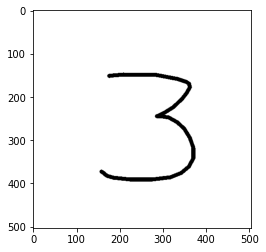

In [111]:
plt.imshow(n_img)

In [112]:
crop_img = get_img_reshape_by_cv2(n_img)
crop_img.shape

(1, 28, 28)

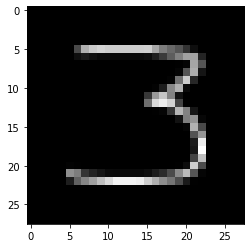

In [113]:
plt.gray()
plt.imshow(crop_img[0])

In [114]:
pred = model.predict(crop_img)

1/1 [==============================] - 0s 26ms/step


In [115]:
np.argmax(pred)

3

In [116]:
num_pred = []


for i in range(len(crop_img)):
    
    if len(crop_img) > 1:
        pred = model.predict(crop_img[i])
    else:
        pred = model.predict(crop_img)
        
    num_pred.append(np.argmax(pred))
num_pred

1/1 [==============================] - 0s 20ms/step


[3]

In [117]:
num_pred, len(num_pred)

([3], 1)

<br>

## Save the trained model

In [121]:
model.save("saved_model.h5")